# A Guide to Topological Data Analysis Ball Mapper in R
Simon Rudkin (University of Manchester)

This notebook accompanies the PDF available on Arxiv at https://doi.org/10.48550/arXiv.2504.14081 . If using the code in this notebook then please be sure to cite the Arxiv paper.

The code will create all of the figures within the guide and can be used as a base for applying Topological Data Anaysis Ball Mapper (TDABM) on any suitable dataset. 

For the examples in this guide, the radius is 0.4 unless otherwise identified

The first step is the loading of the required packages, including the BallMapper package, tidyverse and ggplot2 for generating the scatter plots

In [1]:
library(ggplot2)
library(tidyverse)
library(BallMapper)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


The first step is to create the dataset that will be used throughout the guide. The dataset is a simple bivariate dataset with 500 observations on each of X1 and X2. We also create Y, as the sum of the two X variables

In [2]:
set.seed(123)  # For reproducibility

x1<-runif(500,0,1)
x2<-runif(500,0,1)

df1<-as.data.frame(cbind(x1,x2))
names(df1)<-c("X1","X2")

df1$Y<-df1$X1+df1$X2

# Random Selection of Landmarks

The TDABM algorithm as written in Dlotko (2019) includes the random selection of each landmark from the set of uncovered points. In this section we will construct an equivalent TDABM graph using the artificial dataset and random selection of landmarks. Contrast with the R implementation is provided by subsequent sections.

Within R, a sample of size 1 is used to select the landmark. The selected point then features only the X values

In [3]:
selected_index <- sample(1:nrow(df1), 1)
selected_point <- df1[selected_index, c("X1", "X2")]

The Euclidean distance from all other points to the selected_point is computed

In [4]:
df1$distance <- sqrt((df1$X1 - selected_point$X1)^2 + (df1$X2 - selected_point$X2)^2)

A dummy variable is constructed for all points with the ball radius (0.4) of the selected_point

In [5]:
df1$within_radius <- ifelse(df1$distance <= 0.4, 1, 0)


A data.frame object is constructed which will build with the landmark points. Start with the selected_point

In [6]:
sel<-as.data.frame(selected_point)
names(sel)<-c("X1","X2")

Create a circle around the selected point

In [7]:
theta <- seq(0, 2 * pi, length.out = 200)
radius <- 0.4
circle_df <- data.frame(
  X1 = selected_point$X1 + radius * cos(theta),
  X2 = selected_point$X2 + radius * sin(theta)
)

Construct the first plot with the first ball added

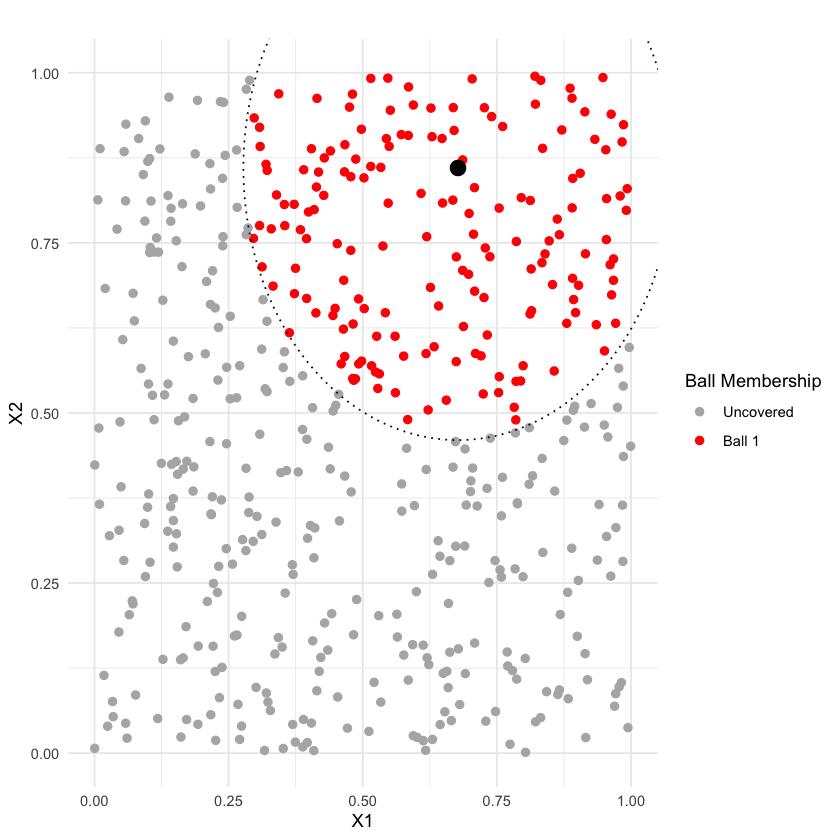

In [8]:
ggplot(df1, aes(x = X1, y = X2, color = factor(within_radius))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
  scale_color_manual(
    values = c("0" = "grey70", "1" = "red"),
    labels = c("Uncovered", "Ball 1"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2")

ggsave("demo001.png", dpi = 300, width = 5.5, height = 4, units = "in")

As the TDABM builds there will be dummy variables for ball membership in the dataframe. We create these now, assigning the membership of Ball 1 as part of the process

In [9]:
df1$ball1<-df1$within_radius
df1$ball2<-0
df1$ball3<-0
df1$ball4<-0
df1$ball5<-0
df1$ball6<-0
df1$intersection<-0

The final element is to capture points in the intersection of two, or more, balls. These intersection points define whether an edge will be drawn in the TDABM plot

In [10]:
df_outside_radius <- df1[df1$within_radius == 0, ]

Then we subset to only those points for which the df_outside_radius is 1 and then select a point by taking a sample of 1 from the set

In [11]:
selected_point2 <- df_outside_radius[sample(nrow(df_outside_radius), 1), ]

The same process of constructing a circle and identifying points within the radius of the selected landmark is again undertaken by measuring the Euclidean distance and then comparing with the ball radius.

In [12]:
df1$distance <- sqrt((df1$X1 - selected_point2$X1)^2 + (df1$X2 - selected_point2$X2)^2)
df1$within_radius2 <- ifelse(df1$distance <= 0.4, 1, 0)

Now we need to know which points are in either ball 1 or the newly created ball 2

In [13]:
df1$with<-df1$within_radius+df1$within_radius2

Finally we need to identify those points which are in only ball 2 and/or in the intersection of ball 1 and ball 2

In [14]:
df1$ball2<-ifelse(df1$within_radius2==1&df1$ball1==0,2,0)
df1$intersection<-ifelse(df1$within_radius2==1&df1$ball1==1,99,0)

Now as a verification exercise we check whether points are in ball 1, ball 2 or the intersection by summing the three elements created by the previous command

In [15]:
df1$member<-df1$ball1+df1$ball2+df1$intersection
df1$with2<-as.numeric(df1$with>0)
df1$member2<-as.numeric(df1$member>0)

summary(df1$with2) # Change to member2 to confirm identical summaries

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   0.754   1.000   1.000 

Prepare the second landmark for inclusion in a merged list of landmarks

In [16]:
selected_point2<-as.data.frame(cbind(selected_point2$X1,selected_point2$X2))
names(selected_point2)<-c("X1","X2")

Row bind with landmark 1

In [17]:
sel = as.data.frame(rbind.data.frame(selected_point,selected_point2))
names(sel)<-c("X1","X2")

The sel object that has been created will be added to with more rows later

Now the circle is constructed around the second landmark

In [18]:
theta <- seq(0, 2 * pi, length.out = 200)
radius <- 0.4
circle_df2 <- data.frame(
  X1 = selected_point2$X1 + radius * cos(theta),
  X2 = selected_point2$X2 + radius * sin(theta)
)

Now the graph with two balls can be plotted. The code generates a png file.

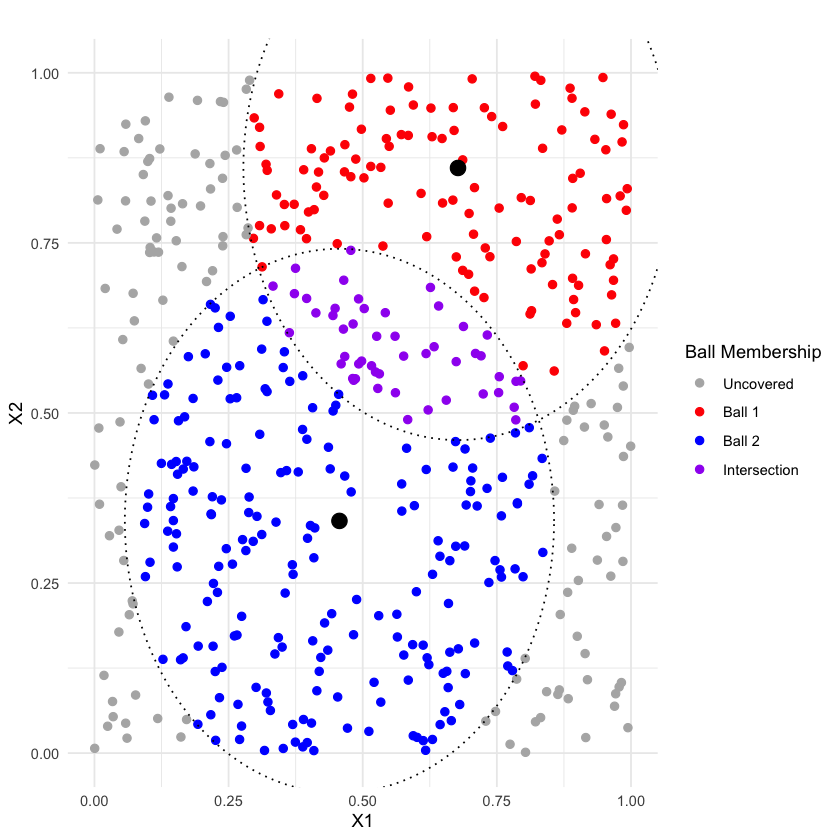

In [19]:
ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
  scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2")

ggsave("demo002.png", dpi = 300, width = 5.5, height = 4, units = "in")

For the third landmark selection, the code has been constructing a variable of ball membership that can be used in the subsetting

In [20]:
df_outside_radius <- df1[df1$member==0, ]

A landmark is selected by using a random sample of 1 again

In [21]:
selected_point3 <- df_outside_radius[sample(nrow(df_outside_radius), 1), ]

Now the distance is calculated

In [22]:
df1$distance <- sqrt((df1$X1 - selected_point3$X1)^2 + (df1$X2 - selected_point3$X2)^2)

Next we produce a dummy for being within the radius of ball 3

In [23]:
df1$within_radius3 <- ifelse(df1$distance <= 0.4, 1, 0)

Prepare the third selected point for adding to the list of selected landmarks

In [24]:
selected_point3<-as.data.frame(cbind(selected_point3$X1,selected_point3$X2))
names(selected_point3)<-c("X1","X2")

sel<-as.data.frame(rbind.data.frame(sel,selected_point3))

Update the balls, recognizing that balls 1 and 2 may have elements in the intersection with ball 3

In [25]:
df1$ball3<-ifelse(df1$within_radius3==1&df1$ball1==0&df1$ball2==0&df1$intersection==0,3,0)
df1$intersection2<-ifelse(df1$within_radius3==1&df1$within_radius==1,99,0)
df1$intersection2<-ifelse(df1$within_radius3==1&df1$within_radius2==1,99,df1$intersection2)
df1$intersection99<-df1$intersection+df1$intersection2
df1$intersection99<-ifelse(df1$intersection99>0,99,0)

Prepare the member dummy for identifying future balls

In [26]:
df1$member<-df1$ball1+df1$ball2+df1$ball3+df1$intersection99

df1$member<-ifelse(df1$member<4,df1$member,100)

Prepare the circle and then generate the plot of the data with three balls. A .png file is created

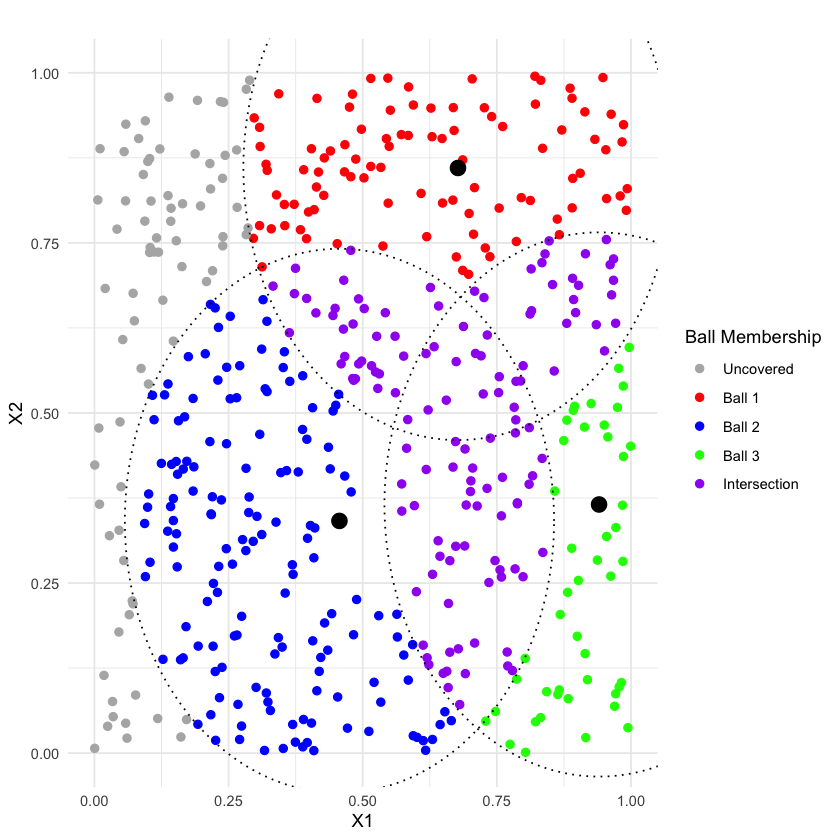

In [27]:
circle_df3 <- data.frame(
  X1 = selected_point3$X1 + radius * cos(theta),
  X2 = selected_point3$X2 + radius * sin(theta)
)

ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
  scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo003.png", dpi = 300, width = 5.5, height = 4, units = "in")

It can be seen that there are still a number of uncovered points to the left of the plot. All of the points on the right are now covered by Ball 3.

For Ball 4, we abridge the code into a single cell. By the end of the cell the 4th landmark is added to the collection of landmarks

In [28]:
df_outside_radius <- df1[df1$member==0, ]

# Select a point at random

selected_point4 <- df_outside_radius[sample(nrow(df_outside_radius), 1), ]

# Compute Euclidean distance to all other points

df1$distance <- sqrt((df1$X1 - selected_point4$X1)^2 + (df1$X2 - selected_point4$X2)^2)

# Create dummy variable: 1 if within radius 0.4, else 0

df1$within_radius4 <- ifelse(df1$distance <= 0.4, 1, 0)

# Convert the selected point into a dataframe

selected_point4<-as.data.frame(cbind(selected_point4$X1,selected_point4$X2))
names(selected_point4)<-c("X1","X2")

# Bind the 4th landmark to the landmark data set

sel<-as.data.frame(rbind.data.frame(sel,selected_point4))

Now we can create the updated membership information

In [29]:
# Create the intersections and membership

df1$ball4<-ifelse(df1$within_radius4==1&df1$ball1==0&df1$ball2==0&df1$ball3==0&df1$intersection99==0,4,0)
df1$intersection3<-ifelse(df1$within_radius4==1&df1$within_radius==1,99,0)
df1$intersection3<-ifelse(df1$within_radius4==1&df1$within_radius2==1,99,df1$intersection3)
df1$intersection3<-ifelse(df1$within_radius4==1&df1$within_radius3==1,99,df1$intersection3)
df1$intersection99<-df1$intersection+df1$intersection2+df1$intersection3
df1$intersection99<-ifelse(df1$intersection99>0,99,0)

# Update the member list

df1$member<-df1$ball1+df1$ball2+df1$ball3+df1$ball4+df1$intersection99

df1$member<-ifelse(df1$member<5,df1$member,100)

Now generate the circle and the plot. Again, a .png file is created showing the data and four balls

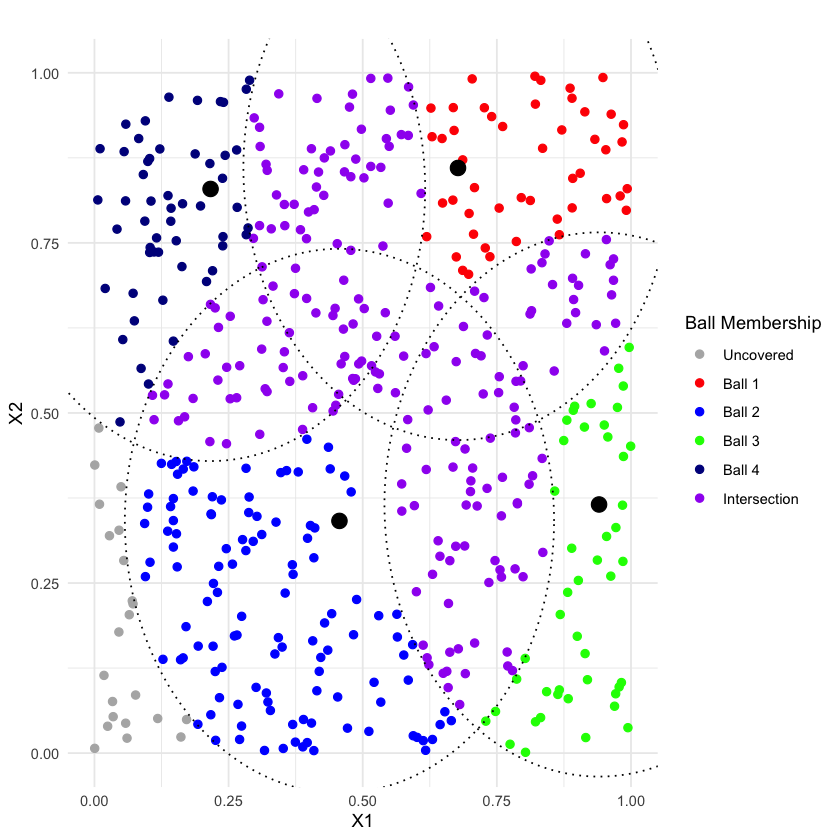

In [30]:
circle_df4 <- data.frame(
  X1 = selected_point4$X1 + radius * cos(theta),
  X2 = selected_point4$X2 + radius * sin(theta)
)

ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df4, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
   scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "4" = "darkblue", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Ball 4", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo004.png", dpi = 300, width = 5.5, height = 4, units = "in")

There are still uncovered points to the lower left.

Again I abridge the code into a single cell, adding the 5th landmark to the selected landmarks list

In [31]:
# Identify points that are not yet in a ball

df_outside_radius <- df1[df1$member==0, ]

# Select a point at random

selected_point5 <- df_outside_radius[sample(nrow(df_outside_radius), 1), ]

# Compute Euclidean distance to all other points

df1$distance <- sqrt((df1$X1 - selected_point5$X1)^2 + (df1$X2 - selected_point5$X2)^2)

# Create dummy variable: 1 if within radius 0.4, else 0

df1$within_radius5 <- ifelse(df1$distance <= 0.4, 1, 0)

# Convert the selected point into a dataframe

selected_point5<-as.data.frame(cbind(selected_point5$X1,selected_point5$X2))
names(selected_point5)<-c("X1","X2")

# Bind the 5th landmark to the landmark data set

sel<-as.data.frame(rbind.data.frame(sel,selected_point5))

Now update the membership list and the member variable

In [32]:
df1$ball5<-ifelse(df1$within_radius5==1&df1$ball1==0&df1$ball2==0&df1$ball3==0&df1$ball4==0&df1$intersection99==0,5,0)
df1$intersection4<-ifelse(df1$within_radius5==1&df1$within_radius==1,99,0)
df1$intersection4<-ifelse(df1$within_radius5==1&df1$within_radius2==1,99,df1$intersection4)
df1$intersection4<-ifelse(df1$within_radius5==1&df1$within_radius3==1,99,df1$intersection4)
df1$intersection4<-ifelse(df1$within_radius5==1&df1$within_radius4==1,99,df1$intersection4)
df1$intersection99<-df1$intersection+df1$intersection2+df1$intersection3+df1$intersection4
df1$intersection99<-ifelse(df1$intersection99>0,99,0)

# Update the member list

df1$member<-df1$ball1+df1$ball2+df1$ball3+df1$ball4+df1$ball5+df1$intersection99

df1$member<-ifelse(df1$member<6,df1$member,100)

Now the circle for ball 5 is created and then the graph with 5 balls plotted

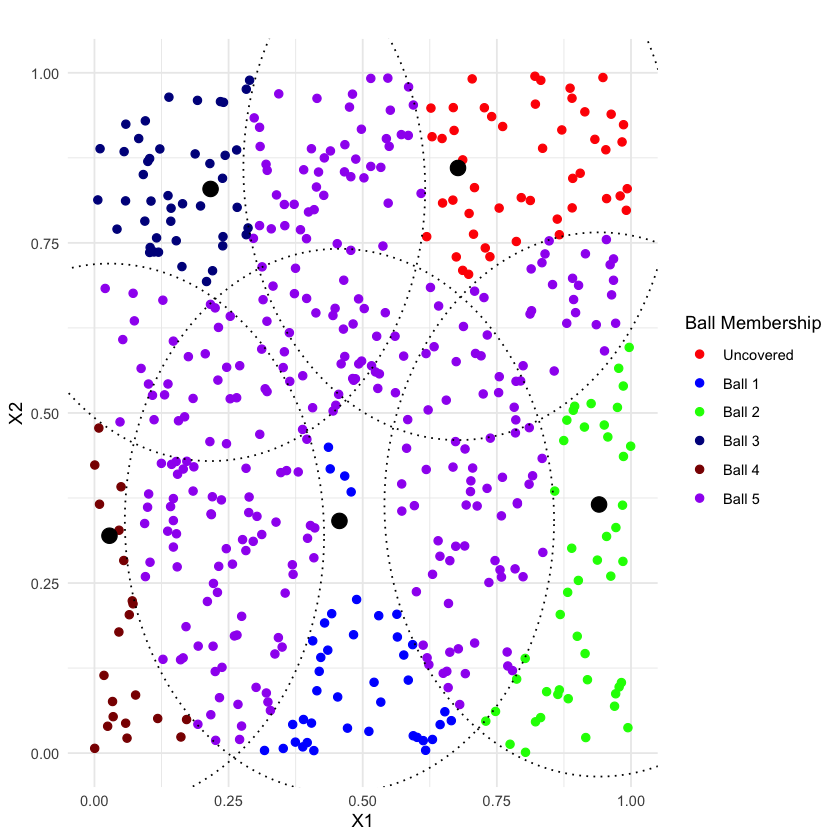

In [33]:
circle_df5 <- data.frame(
  X1 = selected_point5$X1 + radius * cos(theta),
  X2 = selected_point5$X2 + radius * sin(theta)
)

ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df4, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df5, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
   scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "4" = "darkblue", "5" = "darkred","100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Ball 4", "Ball 5", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo005.png", dpi = 300, width = 5.5, height = 4, units = "in")

All points are now covered. The next step is to add the edges that join pairs of points with non-empty intersections

The first step is to create a pairwise list of balls so that the code can check for points in the intersection

In [34]:
sel$id<-seq(1:nrow(sel))
pairs <- expand.grid(id1 = sel$id, id2 = sel$id) %>%
  filter(id1 < id2)  # avoid duplicates and self-pairs

The pairs list is augmented with the X1 and X2 co-ordinates

In [35]:
pairs <- pairs %>%
  left_join(sel, by = c("id1" = "id")) %>%
  rename(x1 = X1, y1 = X2) %>%
  left_join(sel, by = c("id2" = "id")) %>%
  rename(x2 = X1, y2 = X2)

Now check for the pairs that are within a distance of two epsilon. The distance in this case is 0.8 (2 x 0.4)

In [36]:
pairs <- pairs %>%
  mutate(distance = sqrt((x1 - x2)^2 + (y1 - y2)^2)) %>%
  filter(distance < 0.8)

Now generate the plot and save as a .png

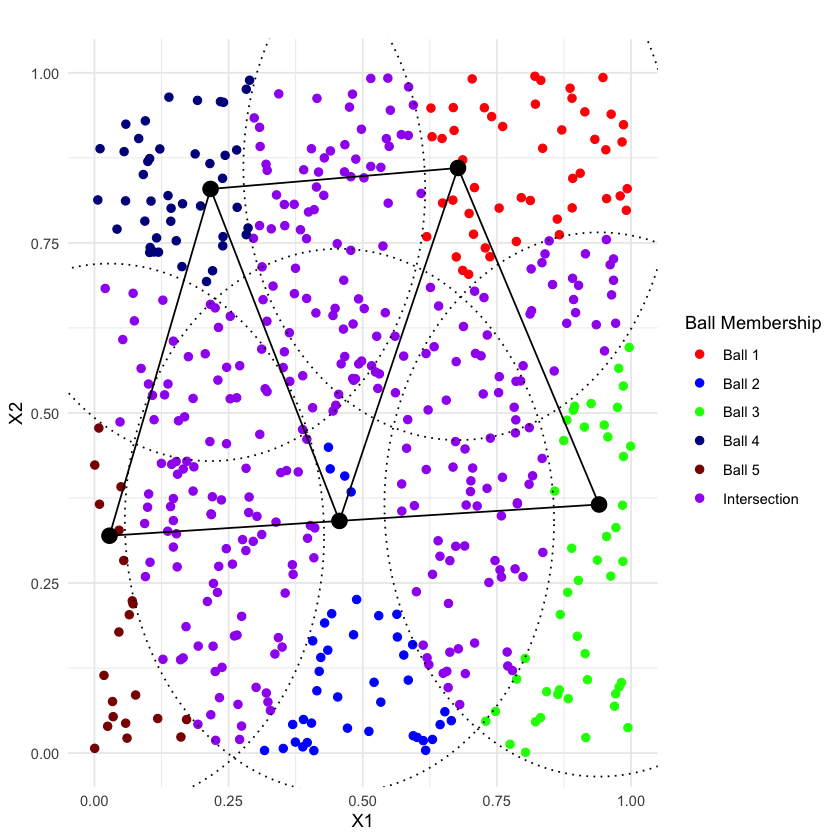

In [37]:
ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df4, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df5, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
  geom_segment(data = pairs,
               aes(x = x1, y = y1, xend = x2, yend = y2),
               color = "black") +
   scale_color_manual(
    values = c("1" = "red", "2" = "blue", "3" = "green", "4" = "darkblue", "5" = "darkred", "100" = "purple"),
    labels = c("Ball 1", "Ball 2", "Ball 3", "Ball 4", "Ball 5", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")


ggsave("demo008.png", dpi = 300, width = 5.5, height = 4, units = "in")

It would now be possible to size the landmarks according to the number of points within the ball and to color as a function of the ball members. This file will only do the coloring and sizing with the version that mirrors the R implementation of the TDABM algorithm

## Following the TDABM Algorithm in R

The implementation of TDABM in R uses the dataset in the order that it is passed to the algorithm. The next landmark is always the first data point in the uncovered set. Having the algorithm predictably select points ensures replicaiton and allows the user to iterate over random ordering of the data to obtain bootstrap estimates of any statistics from the TDABM plot. 

Because the previous section added a large number of columns to the dataset I will create a new version of the dataset here. The code is identical to previously. The difference comes in the final line where a row id column is added. The row id is called pt, representing the data point

In [38]:
# Recreate the dataset

set.seed(123)  # For reproducibility

x1<-runif(500,0,1)
x2<-runif(500,0,1)

df1<-as.data.frame(cbind(x1,x2))
names(df1)<-c("X1","X2")

# Add a column with the point IDs

df1$pt<-seq(1:nrow(df1)) 

Landmark 1 for the ball is straightforward to select as it is the first point in the dataset. Landmark 1 has pt = 1

In [39]:
selected_point <- df1[1, c("X1", "X2")]

All points are then measured to the selected point. This distance allows the identification of points within a ball

In [40]:
df1$distance <- sqrt((df1$X1 - selected_point$X1)^2 + (df1$X2 - selected_point$X2)^2)

Then the points within the radius of 0.4 are identified

In [41]:
df1$within_radius <- ifelse(df1$distance <= 0.4, 1, 0)

There will be a set of dummies for each ball. It is already known how many balls there will be, but if necessary more balls could be added later

In [42]:
df1$ball1<-df1$within_radius
df1$ball2<-0
df1$ball3<-0
df1$ball4<-0
df1$ball5<-0
df1$ball6<-0
df1$ball7<-0
df1$intersection<-0

The final dummy is for points in the intersection. The intersection is colored identically irrespective of for which balls is being found.

An object is created to store all of the information about the selected landmarks

In [43]:
sel<-as.data.frame(selected_point)
names(sel)<-c("X1","X2")

A circle is drawn around the selected landmark. This is ball 1

In [44]:
theta <- seq(0, 2 * pi, length.out = 200)
radius <- 0.4
circle_df <- data.frame(
  X1 = selected_point$X1 + radius * cos(theta),
  X2 = selected_point$X2 + radius * sin(theta)
)

A plot is drawn and the file saved as a .png

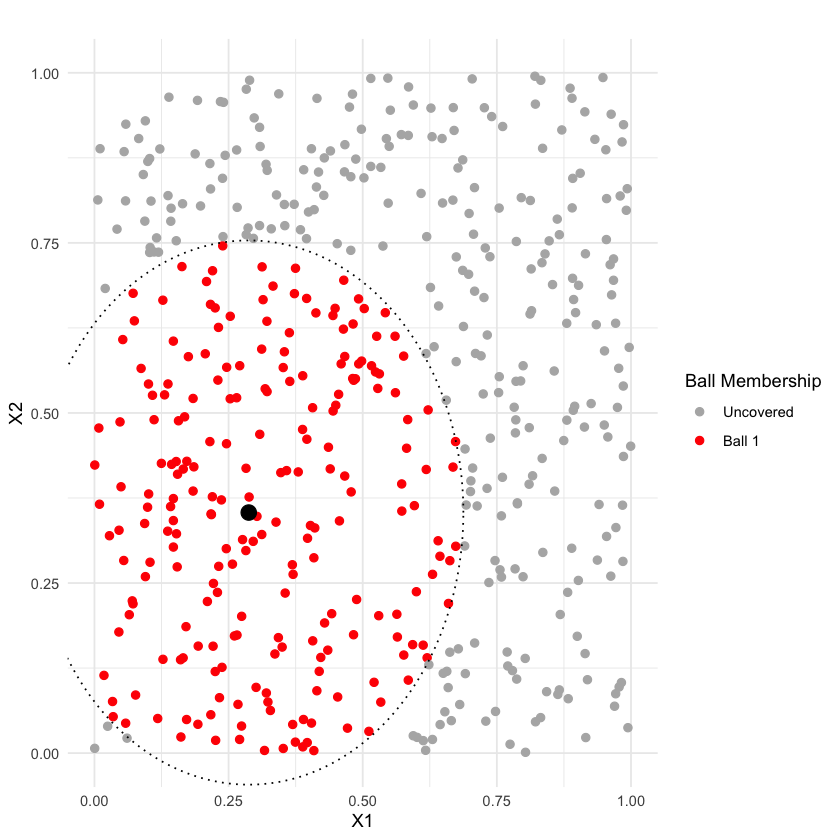

In [45]:
ggplot(df1, aes(x = X1, y = X2, color = factor(within_radius))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
  scale_color_manual(
    values = c("0" = "grey70", "1" = "red"),
    labels = c("Uncovered", "Ball 1"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2")

ggsave("demo101.png", dpi = 300, width = 5.5, height = 4, units = "in")

It can be seen that the selected ball omits a small group of 3 points to the lower left. This will need another ball as part of the construction. 

To find the landmark for ball 2, it is first necessary to subset to the uncovered points. The value of the pt variable is the id of the point which will become to next landmark. Let us call the id minid

In [46]:
unc<-subset(df1,df1$within_radius==0)
minid<-min(unc$pt)

Find the selected point in the dataset

In [47]:
selected_point2 <- df1[minid, c("X1", "X2")]

Then calculate the distances between all points and the selected point

In [48]:
df1$distance <- sqrt((df1$X1 - selected_point2$X1)^2 + (df1$X2 - selected_point2$X2)^2)

The identification of ball membership and intersection presence follows the same approach as previously

In [49]:
df1$within_radius2 <- ifelse(df1$distance <= 0.4, 1, 0)
df1$with<-df1$within_radius+df1$within_radius2

# Update the only ball 2 dummy and a dummy for the intersection

df1$ball2<-ifelse(df1$within_radius2==1&df1$ball1==0,2,0)
df1$intersection<-ifelse(df1$within_radius2==1&df1$ball1==1,99,0)

df1$member<-df1$ball1+df1$ball2+df1$intersection

The selected landmark for ball 2 is formatted and then joined into the list of landmarks

In [50]:
selected_point2<-as.data.frame(cbind(selected_point2$X1,selected_point2$X2))
names(selected_point2)<-c("X1","X2")

# Bind the two selected points together

sel = as.data.frame(rbind.data.frame(selected_point,selected_point2))
names(sel)<-c("X1","X2")

A circle is now constructed to represent the ball around landmark 2. The graph can then be plotted. The code generates a .png

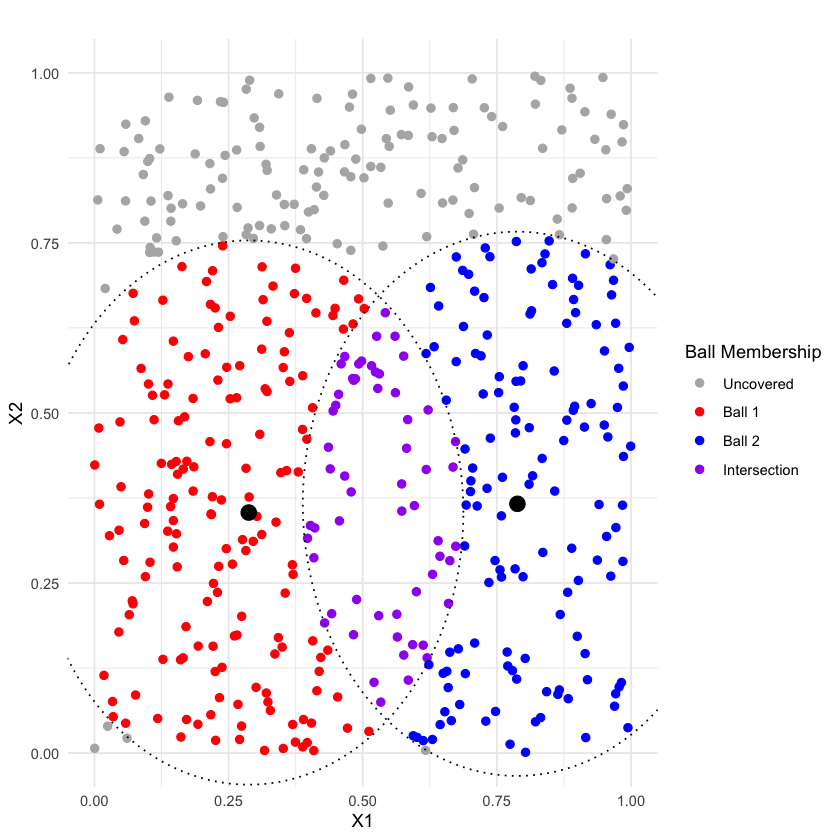

In [51]:
theta <- seq(0, 2 * pi, length.out = 200)
radius <- 0.4
circle_df2 <- data.frame(
  X1 = selected_point2$X1 + radius * cos(theta),
  X2 = selected_point2$X2 + radius * sin(theta)
)

# Generate the plot

ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
  scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2")

ggsave("demo102.png", dpi = 300, width = 5.5, height = 4, units = "in")

There is a small pocket of three points down to the bottom left of the plot still, but the second ball has covered all of the points in the lower right.  There is however a single point which is located around X1 = 0.61, X2 = 0 which is not covered.

I continue to identify the uncovered points, such that the lowest pt number in the uncovered set may be identified as the third landmark.

In [52]:
unc<-subset(df1,df1$member==0)
minid<-min(unc$pt)

selected_point3 <- df1[minid, c("X1", "X2")]

Now the distance from the selected point is calculated. The selected point is added to the table of landmarks.

In [53]:
# Compute Euclidean distance to all other points

df1$distance <- sqrt((df1$X1 - selected_point3$X1)^2 + (df1$X2 - selected_point3$X2)^2)

# Create dummy variable: 1 if within radius 0.4, else 0

df1$within_radius3 <- ifelse(df1$distance <= 0.4, 1, 0)

# Prepare selected point 3 for adding to the dataframe of landmarks

selected_point3<-as.data.frame(cbind(selected_point3$X1,selected_point3$X2))
names(selected_point3)<-c("X1","X2")

# Add to the dataframe of landmarks

sel<-as.data.frame(rbind.data.frame(sel,selected_point3))

The ball memberships and intersections are updated

In [54]:
df1$ball3<-ifelse(df1$within_radius3==1&df1$ball1==0&df1$ball2==0&df1$intersection==0,3,0)
df1$intersection2<-ifelse(df1$within_radius3==1&df1$within_radius==1,99,0)
df1$intersection2<-ifelse(df1$within_radius3==1&df1$within_radius2==1,99,df1$intersection2)
df1$intersection99<-df1$intersection+df1$intersection2
df1$intersection99<-ifelse(df1$intersection99>0,99,0)

# Update the membership variable to allow for the third ball

df1$member<-df1$ball1+df1$ball2+df1$ball3+df1$intersection99

df1$member<-ifelse(df1$member<4,df1$member,100)

Next for ball 3 I construct the circle around the landmark and plot the graph. This code will create a .png file

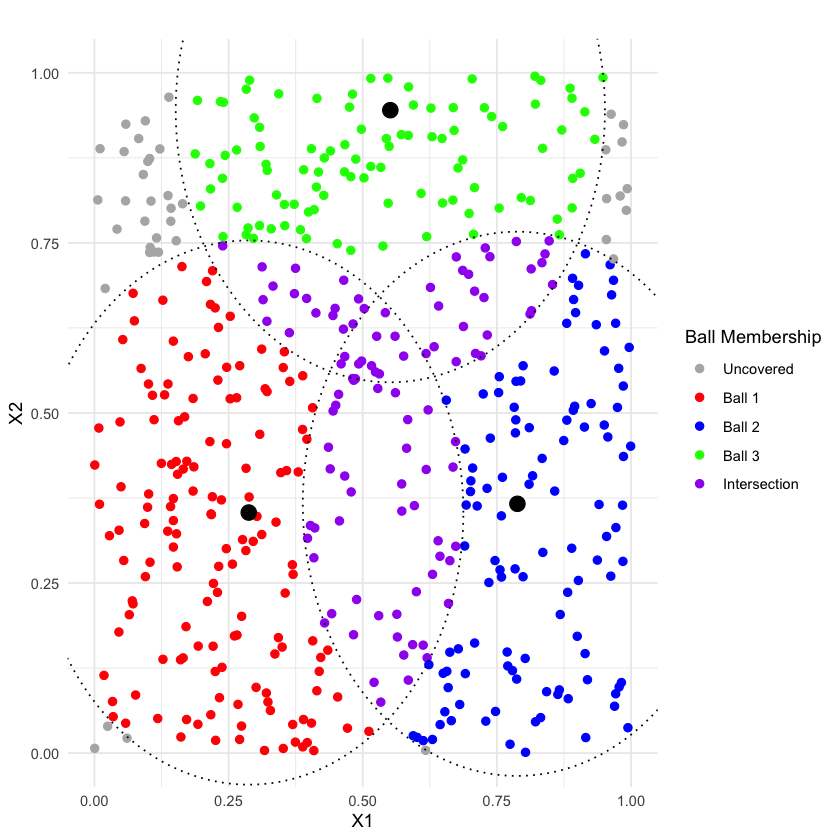

In [55]:
circle_df3 <- data.frame(
  X1 = selected_point3$X1 + radius * cos(theta),
  X2 = selected_point3$X2 + radius * sin(theta)
)

ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
  scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo103.png", dpi = 300, width = 5.5, height = 4, units = "in")

There are now three small pockets of uncovered points, one to the lower left, one to the upper left and one to the upper right. The single point below ball 2 is also uncovered. This means that 7 balls will be required.

The process for ball 4 is the same as previously. First the uncovered subset is created and the first ID identified

In [56]:
unc<-subset(df1,df1$member==0)
minid<-min(unc$pt)

selected_point4 <- df1[minid, c("X1", "X2")]

The distances to all points are calculated and the ball memberships updated

In [57]:
df1$distance <- sqrt((df1$X1 - selected_point4$X1)^2 + (df1$X2 - selected_point4$X2)^2)

# Create dummy variable: 1 if within radius 0.4, else 0

df1$within_radius4 <- ifelse(df1$distance <= 0.4, 1, 0)

# Convert the selected point into a dataframe

selected_point4<-as.data.frame(cbind(selected_point4$X1,selected_point4$X2))
names(selected_point4)<-c("X1","X2")

# Bind the 4th landmark to the landmark data set

sel<-as.data.frame(rbind.data.frame(sel,selected_point4))

# Create the intersections and membership

df1$ball4<-ifelse(df1$within_radius4==1&df1$ball1==0&df1$ball2==0&df1$ball3==0&df1$intersection99==0,4,0)
df1$intersection3<-ifelse(df1$within_radius4==1&df1$within_radius==1,99,0)
df1$intersection3<-ifelse(df1$within_radius4==1&df1$within_radius2==1,99,df1$intersection3)
df1$intersection3<-ifelse(df1$within_radius4==1&df1$within_radius3==1,99,df1$intersection3)
df1$intersection99<-df1$intersection+df1$intersection2+df1$intersection3
df1$intersection99<-ifelse(df1$intersection99>0,99,0)

# Update the member list

df1$member<-df1$ball1+df1$ball2+df1$ball3+df1$ball4+df1$intersection99

df1$member<-ifelse(df1$member<5,df1$member,100)

The circle is created and the graph plotted. The code generates a .png file

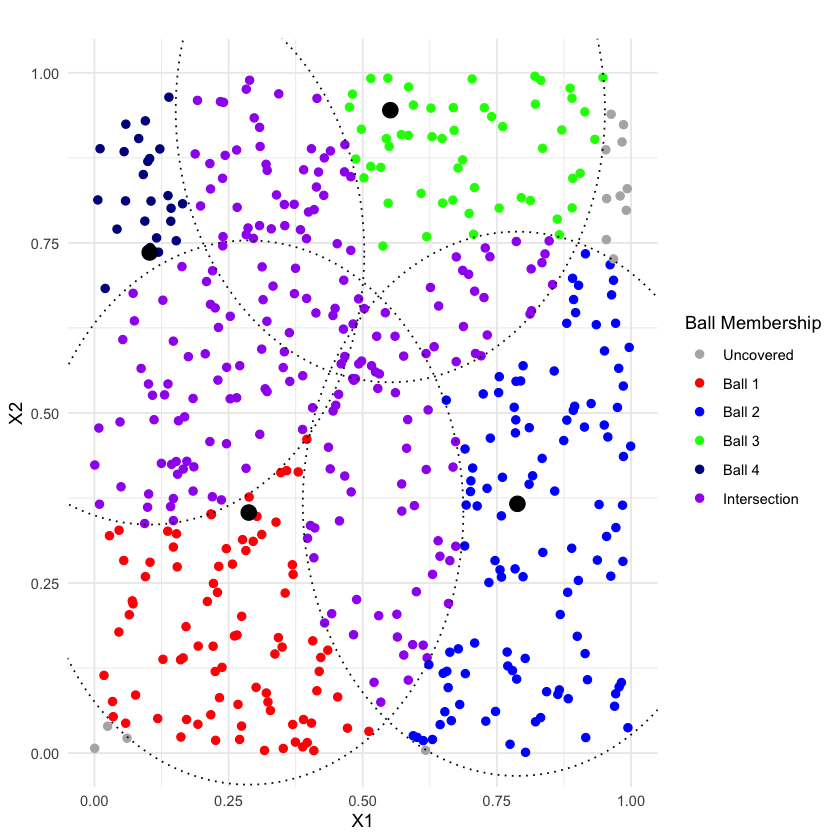

In [58]:
circle_df4 <- data.frame(
  X1 = selected_point4$X1 + radius * cos(theta),
  X2 = selected_point4$X2 + radius * sin(theta)
)

ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df4, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
   scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "4" = "darkblue", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Ball 4", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo104.png", dpi = 300, width = 5.5, height = 4, units = "in")

Ball 4 covered the group of uncovered points to the upper left. There are now three pockets uncovered.

In [60]:
unc<-subset(df1,df1$member==0)
minid<-min(unc$pt)

# We now identify the point in the dataset

selected_point5 <- df1[minid, c("X1", "X2")]

selected_point5<-as.data.frame(cbind(selected_point5$X1,selected_point5$X2))
names(selected_point5)<-c("X1","X2")

sel<-as.data.frame(rbind.data.frame(sel,selected_point5))

Now find the distance between all points and the 5th landmark. Identify which points are with a radius of 0.4 of the new landmark. Finally, the memberships are updated

In [61]:
df1$distance <- sqrt((df1$X1 - selected_point5$X1)^2 + (df1$X2 - selected_point5$X2)^2)

# Create dummy variable: 1 if within radius 0.4, else 0

df1$within_radius5 <- ifelse(df1$distance <= 0.4, 1, 0)

# Create the intersections and membership

df1$ball5<-ifelse(df1$within_radius5==1&df1$ball1==0&df1$ball2==0&df1$ball3==0&df1$ball4==0&df1$intersection99==0,5,0)
df1$intersection4<-ifelse(df1$within_radius5==1&df1$within_radius==1,99,0)
df1$intersection4<-ifelse(df1$within_radius5==1&df1$within_radius2==1,99,df1$intersection4)
df1$intersection4<-ifelse(df1$within_radius5==1&df1$within_radius3==1,99,df1$intersection4)
df1$intersection4<-ifelse(df1$within_radius5==1&df1$within_radius4==1,99,df1$intersection4)
df1$intersection99<-df1$intersection+df1$intersection2+df1$intersection3+df1$intersection4
df1$intersection99<-ifelse(df1$intersection99>0,99,0)

# Update the member list

df1$member<-df1$ball1+df1$ball2+df1$ball3+df1$ball4+df1$ball5+df1$intersection99

df1$member<-ifelse(df1$member<6,df1$member,100)

Now draw the circle and add to the plot. This will produce an updated .png file

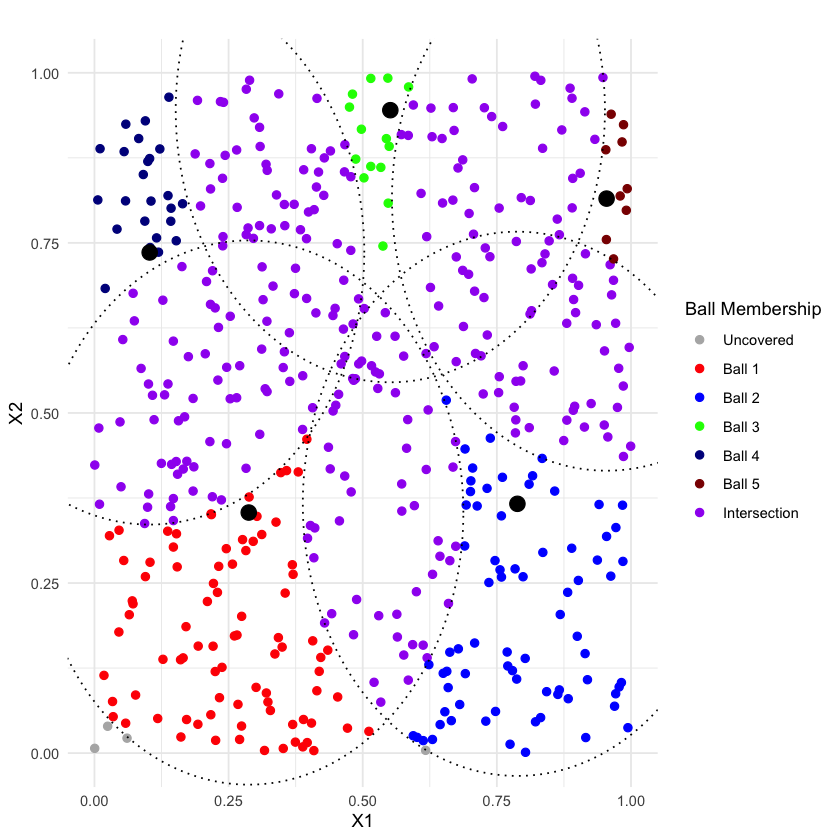

In [62]:
circle_df5 <- data.frame(
  X1 = selected_point5$X1 + radius * cos(theta),
  X2 = selected_point5$X2 + radius * sin(theta)
)

ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df4, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df5, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
   scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "4" = "darkblue", "5" = "darkred","100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Ball 4", "Ball 5", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo105.png", dpi = 300, width = 5.5, height = 4, units = "in")

The top part of the plot is now covered. There are the three points to the lower left and the single point outside ball 2 remaining.

The same process selects the landmark for ball 6 and then adds the point to the set of landmarks

In [63]:
unc<-subset(df1,df1$member==0)
minid<-min(unc$pt)

selected_point6 <- df1[minid, c("X1", "X2")]

selected_point6<-as.data.frame(cbind(selected_point6$X1,selected_point6$X2))
names(selected_point6)<-c("X1","X2")

# Bind the 6th landmark to the landmark data set

sel<-as.data.frame(rbind.data.frame(sel,selected_point6))

Then distances to the new landmark are calculated and the members of ball 6 identified

In [64]:
df1$distance <- sqrt((df1$X1 - selected_point6$X1)^2 + (df1$X2 - selected_point6$X2)^2)

# Create dummy variable: 1 if within radius 0.4, else 0

df1$within_radius6 <- ifelse(df1$distance <= 0.4, 1, 0)

df1$ball6<-ifelse(df1$within_radius6==1&df1$ball1==0&df1$ball2==0&df1$ball3==0&df1$ball4==0&df1$ball5==0&df1$intersection99==0,6,0)
df1$intersection5<-ifelse(df1$within_radius6==1&df1$within_radius==1,99,0)
df1$intersection5<-ifelse(df1$within_radius6==1&df1$within_radius2==1,99,df1$intersection5)
df1$intersection5<-ifelse(df1$within_radius6==1&df1$within_radius3==1,99,df1$intersection5)
df1$intersection5<-ifelse(df1$within_radius6==1&df1$within_radius4==1,99,df1$intersection5)
df1$intersection5<-ifelse(df1$within_radius6==1&df1$within_radius5==1,99,df1$intersection5)
df1$intersection99<-df1$intersection+df1$intersection2+df1$intersection3+df1$intersection4+df1$intersection5
df1$intersection99<-ifelse(df1$intersection99>0,99,0)

# Update the member list

df1$member<-df1$ball1+df1$ball2+df1$ball3+df1$ball4+df1$ball5+df1$ball6+df1$intersection99

df1$member<-ifelse(df1$member<8,df1$member,100)

Finally, for ball 6, we create the circle and then draw the graph. A .png file is created to add to the set already produced

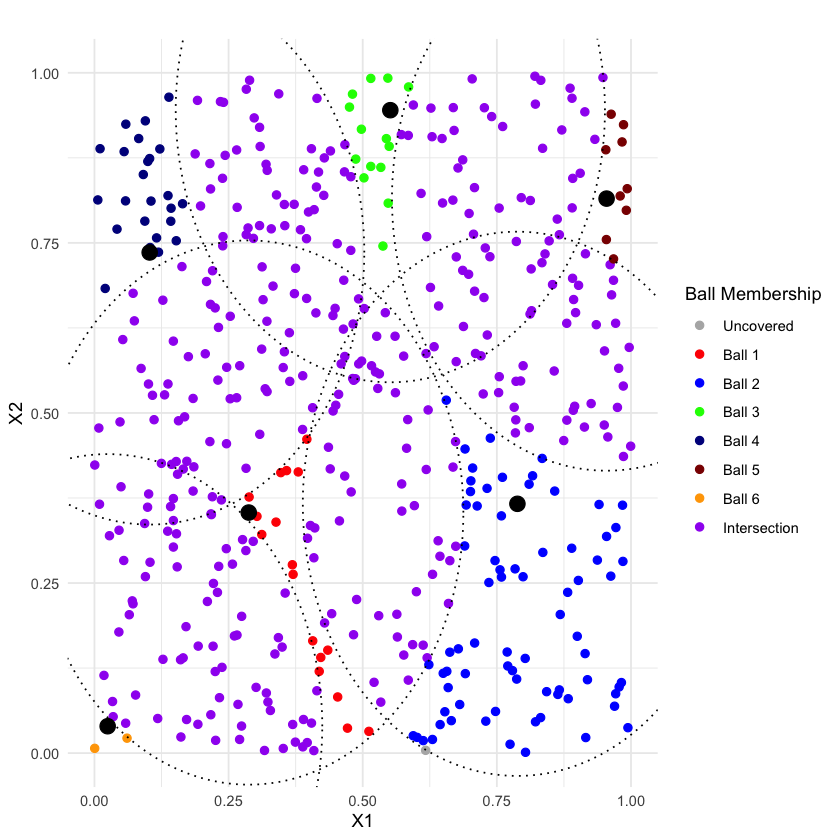

In [65]:
circle_df6 <- data.frame(
  X1 = selected_point6$X1 + radius * cos(theta),
  X2 = selected_point6$X2 + radius * sin(theta)
)

ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df4, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df5, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
geom_path(data = circle_df6, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
   scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "4" = "darkblue", "5" = "darkred","6" = "orange", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Ball 4", "Ball 5", "Ball 6", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo106.png", dpi = 300, width = 5.5, height = 4, units = "in")

The final uncovered points is the one just outside ball 2. That will be the landmark, but I still go through the formal process of identifying the landmark

In [66]:
unc<-subset(df1,df1$member==0)
minid<-min(unc$pt)

selected_point7 <- df1[minid, c("X1", "X2")]

selected_point7<-as.data.frame(cbind(selected_point7$X1,selected_point7$X2))
names(selected_point7)<-c("X1","X2")

# Bind the 6th landmark to the landmark data set

sel<-as.data.frame(rbind.data.frame(sel,selected_point7))

The points within the ball surrounding landmark 7 are identified. Membership varaibles are updated.

In [68]:
df1$distance <- sqrt((df1$X1 - selected_point7$X1)^2 + (df1$X2 - selected_point7$X2)^2)

# Create dummy variable: 1 if within radius 0.4, else 0

df1$within_radius7 <- ifelse(df1$distance <= 0.4, 1, 0)

df1$ball7<-ifelse(df1$within_radius7==1&df1$ball1==0&df1$ball2==0&df1$ball3==0&df1$ball4==0&df1$ball5==0&df1$ball6==0&df1$intersection99==0,7,0)
df1$intersection6<-ifelse(df1$within_radius7==1&df1$within_radius==1,99,0)
df1$intersection6<-ifelse(df1$within_radius7==1&df1$within_radius2==1,99,df1$intersection6)
df1$intersection6<-ifelse(df1$within_radius7==1&df1$within_radius3==1,99,df1$intersection6)
df1$intersection6<-ifelse(df1$within_radius7==1&df1$within_radius4==1,99,df1$intersection6)
df1$intersection6<-ifelse(df1$within_radius7==1&df1$within_radius5==1,99,df1$intersection6)
df1$intersection6<-ifelse(df1$within_radius7==1&df1$within_radius6==1,99,df1$intersection6)
df1$intersection99<-df1$intersection+df1$intersection2+df1$intersection3+df1$intersection4+df1$intersection5+df1$intersection6
df1$intersection99<-ifelse(df1$intersection99>0,99,0)

# Update the member list

df1$member<-df1$ball1+df1$ball2+df1$ball3+df1$ball4+df1$ball5+df1$ball6+df1$ball7+df1$intersection99

df1$member<-ifelse(df1$member<9,df1$member,100)

The graph is then plotted, confirming that there are no uncovered points remaining.

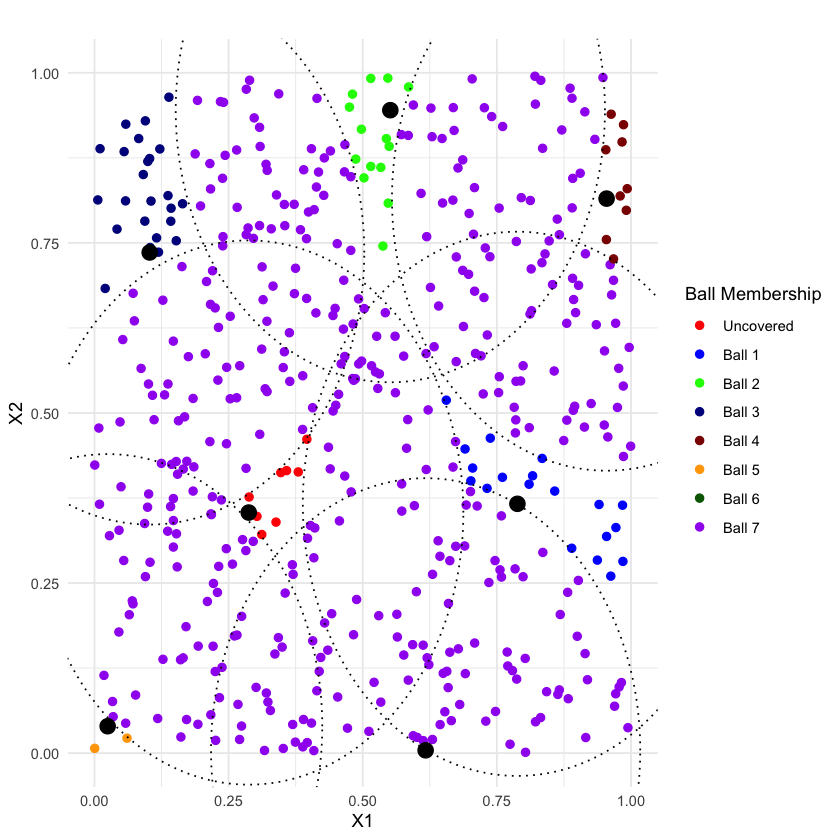

In [69]:
circle_df7 <- data.frame(
  X1 = selected_point7$X1 + radius * cos(theta),
  X2 = selected_point7$X2 + radius * sin(theta)
)

ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df4, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df5, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df6, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df7, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
   scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "4" = "darkblue", "5" = "darkred","6" = "orange","7" = "darkgreen", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Ball 4", "Ball 5", "Ball 6", "Ball 7", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo107.png", dpi = 300, width = 5.5, height = 4, units = "in")

The creation of the final ball means that there is a landmark just outside ball 2. The cover is now completed and so I move to identify the non-empty intersections between pairs of balls

In [71]:
sel$id<-seq(1:nrow(sel))
pairs <- expand.grid(id1 = sel$id, id2 = sel$id) %>%
  filter(id1 < id2)  # avoid duplicates and self-pairs


Next the pairs are joined with their X1 and X2 coordinates

In [72]:
pairs <- pairs %>%
  left_join(sel, by = c("id1" = "id")) %>%
  rename(x1 = X1, y1 = X2) %>%
  left_join(sel, by = c("id2" = "id")) %>%
  rename(x2 = X1, y2 = X2)

Finally identify the pairs where the distances are short

In [73]:
# Compute distances
pairs <- pairs %>%
  mutate(distance = sqrt((x1 - x2)^2 + (y1 - y2)^2)) %>%
  filter(distance < 0.8)

The graph is now updated with the edges drawn between the points

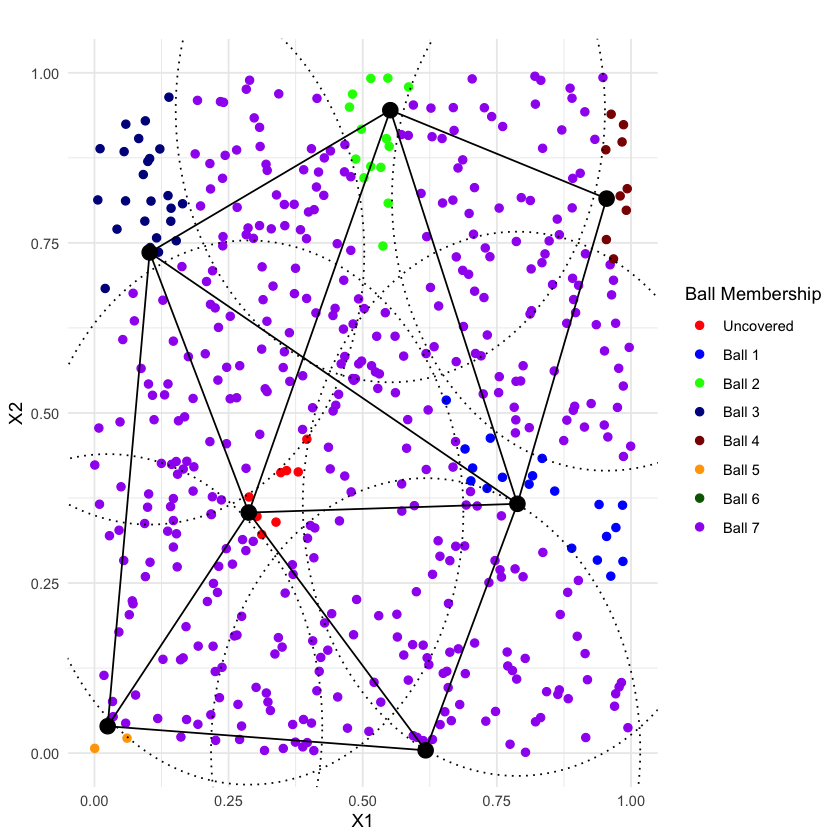

In [74]:
ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df4, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df5, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df6, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df7, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = sel, aes(x=X1, y=X2), color="black",size=4)+
  geom_segment(data = pairs,
               aes(x = x1, y = y1, xend = x2, yend = y2),
               color = "black") +
   scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "4" = "darkblue", "5" = "darkred","6" = "orange","7" = "darkgreen", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Ball 4", "Ball 5", "Ball 6", "Ball 7", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo108.png", dpi = 300, width = 5.5, height = 4, units = "in")

Next I will size the landmark points so that they reflect the number of points within their respective balls

In [75]:
ptct<-as.data.frame(matrix(0,nrow=7,ncol=2))
names(ptct)<-c("Ball","Count")

ptct$Ball<-seq(1:7)


The elements of this data frame are filled in manually (Note it would be possible to create a function to perform this task, but because we are only creating an example it is instructive to keep the individual lines)

In [76]:
df1a<-subset(df1,df1$within_radius>0)
ptct$Count[1]<-nrow(df1a)
df1a<-subset(df1,df1$within_radius2>0)
ptct$Count[2]<-nrow(df1a)
df1a<-subset(df1,df1$within_radius3>0)
ptct$Count[3]<-nrow(df1a)
df1a<-subset(df1,df1$within_radius4>0)
ptct$Count[4]<-nrow(df1a)
df1a<-subset(df1,df1$within_radius5>0)
ptct$Count[5]<-nrow(df1a)
df1a<-subset(df1,df1$within_radius6>0)
ptct$Count[6]<-nrow(df1a)
df1a<-subset(df1,df1$within_radius7>0)
ptct$Count[7]<-nrow(df1a)

I then create a scaled version of the count to determine the sizes in the plot. The scale is set between 5 and 15 as these are reasonable sizes for an R plot.

In [77]:
ptct<-as.data.frame(cbind(sel,ptct))

min_val<-min(ptct$Count)
max_val<-max(ptct$Count)

ptct$C_scaled <- 2 + (ptct$Count - min_val) * (15 - 5) / (max_val - min_val)

The graph is plotted with the sized landmarks over the top of the data

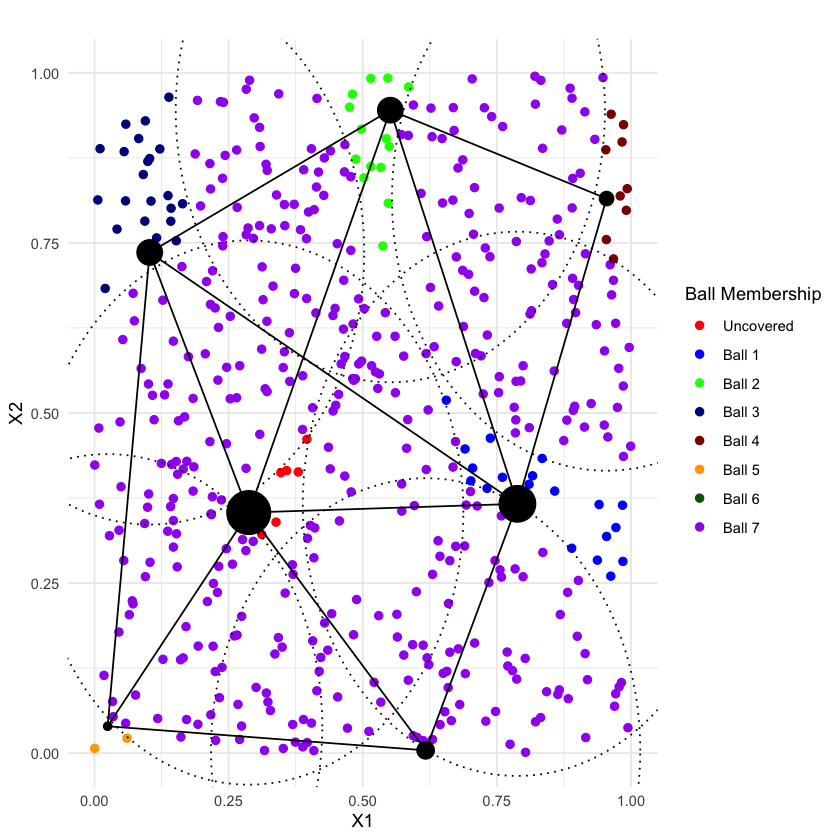

In [78]:
ggplot(df1, aes(x = X1, y = X2, color = factor(member))) +
  geom_point(size = 2) +
  geom_path(data = circle_df, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df2, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df3, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df4, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df5, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df6, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_path(data = circle_df7, aes(x = X1, y = X2),
            inherit.aes = FALSE, linetype = "dotted", color = "black") +
  geom_point(data = ptct, aes(x=X1, y=X2), color="black",size= ptct$C_scaled)+
  geom_segment(data = pairs,
               aes(x = x1, y = y1, xend = x2, yend = y2),
               color = "black") +
   scale_color_manual(
    values = c("0" = "grey70", "1" = "red", "2" = "blue", "3" = "green", "4" = "darkblue", "5" = "darkred","6" = "orange","7" = "darkgreen", "100" = "purple"),
    labels = c("Uncovered", "Ball 1", "Ball 2", "Ball 3", "Ball 4", "Ball 5", "Ball 6", "Ball 7", "Intersection"),
    name = "Ball Membership"
  ) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color="Ball Membership")

ggsave("demo109.png", dpi = 300, width = 5.5, height = 4, units = "in")

The data points can then be removed to produce a further version of the TDABM graph

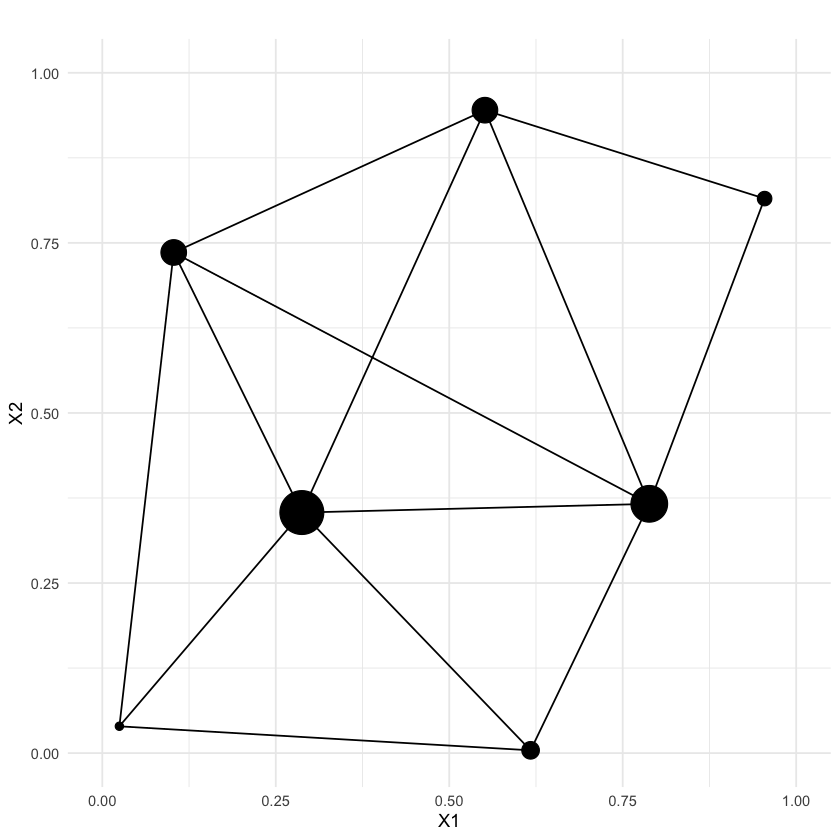

In [79]:
ggplot(ptct, aes(x = X1, y = X2)) +
  geom_point(size = ptct$C_scaled) +
  geom_segment(data = pairs,
               aes(x = x1, y = y1, xend = x2, yend = y2),
               color = "black") +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2")

ggsave("demo110.png", dpi = 300, width = 5.5, height = 4, units = "in")

With TDABM landmarks are colored. However, to this point there is no variable to color by. 

In [81]:
df1$Y<-df1$X1+df1$X2

Then a version of the plot is created without the grid that has been generated from the TDABM so that there is a reference point

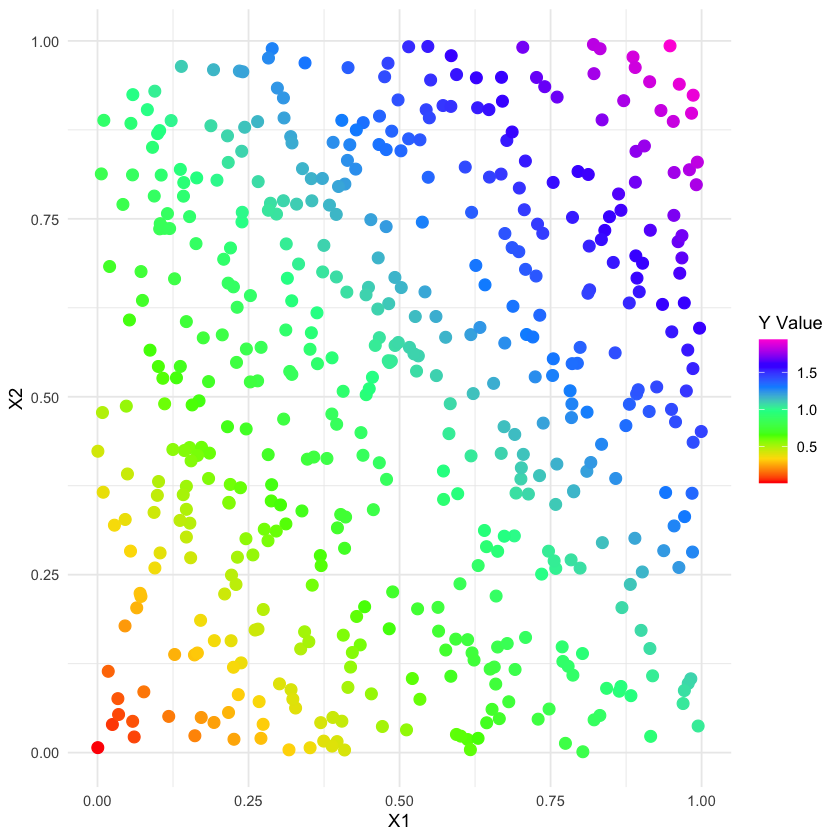

In [82]:
# Generate a scatter plot colored by outcomes

ggplot(data = df1, aes(x = X1, y = X2, color = Y)) +
  geom_point(size = 3) +
  scale_color_gradientn(colours = rainbow(7)) +  # Rainbow color scale
  theme_minimal() +
  labs(color = "Y Value")  # Title for colorbar

ggsave("demo000.png", dpi = 300, width = 5.5, height = 4, units = "in")

Next, bring back the grid to overlay on the colored points

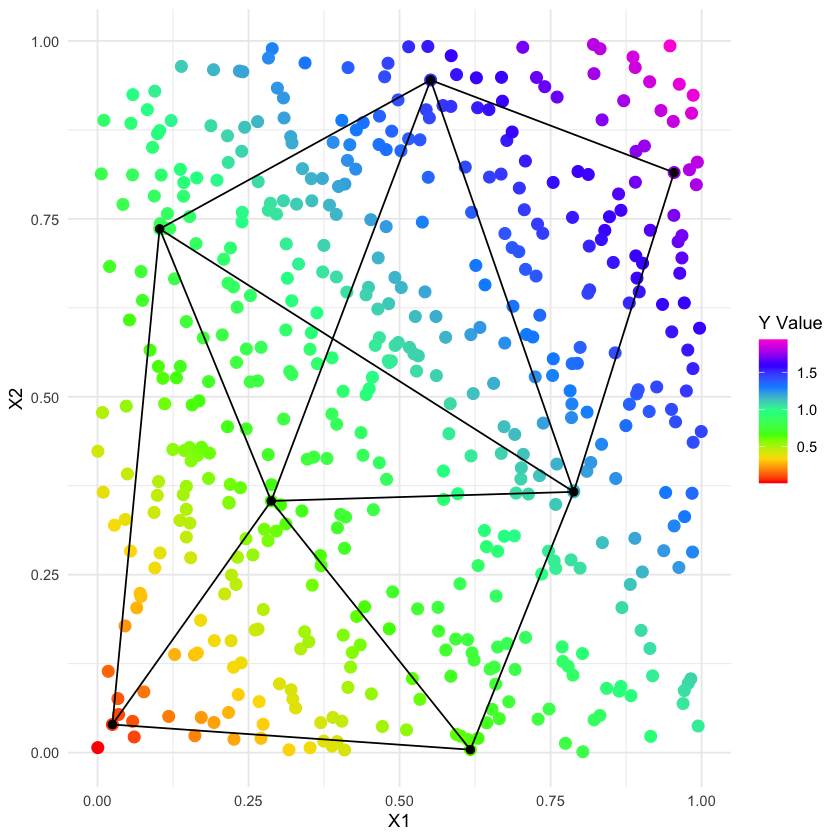

In [83]:
ggplot(data = df1, aes(x = X1, y = X2, color = Y)) +
  geom_point(size = 3) +
  geom_point(data = ptct, aes(x=X1, y=X2), color="black",size=2)+
  geom_segment(data = pairs,
               aes(x = x1, y = y1, xend = x2, yend = y2),
               color = "black") +
  scale_color_gradientn(colours = rainbow(7)) +  # Rainbow color scale
  theme_minimal() +
  labs(color = "Y Value")  # Title for colorbar

ggsave("demo201.png", dpi = 300, width = 5.5, height = 4, units = "in")

To show the addition of the mean of Y to the landmarks dataset, I show each line independently. The mean function here can be updated with any function desired

In [84]:
df1a<-subset(df1,df1$within_radius>0)
ptct$Color[1]<-mean(df1a$Y)
df1a<-subset(df1,df1$within_radius2>0)
ptct$Color[2]<-mean(df1a$Y)
df1a<-subset(df1,df1$within_radius3>0)
ptct$Color[3]<-mean(df1a$Y)
df1a<-subset(df1,df1$within_radius4>0)
ptct$Color[4]<-mean(df1a$Y)
df1a<-subset(df1,df1$within_radius5>0)
ptct$Color[5]<-mean(df1a$Y)
df1a<-subset(df1,df1$within_radius6>0)
ptct$Color[6]<-mean(df1a$Y)
df1a<-subset(df1,df1$within_radius7>0)
ptct$Color[7]<-mean(df1a$Y)

The graph can now be drawn using the Y as the colors of the landmarks

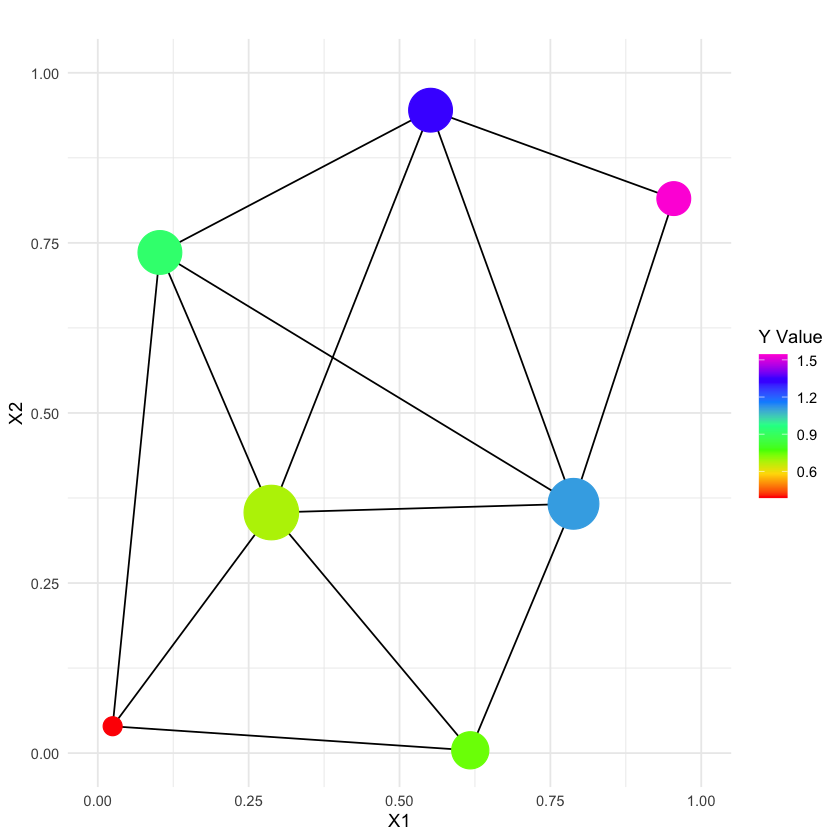

In [85]:
ggplot(ptct, aes(x = X1, y = X2, color = Color)) +
  geom_segment(data = pairs,
               aes(x = x1, y = y1, xend = x2, yend = y2),
               color = "black") +
  geom_point(aes(color = Color, size = C_scaled)) +
  scale_color_gradientn(colours = rainbow(7)) +  # Rainbow color scale
  scale_size(range = c(5, 15)) + 
  guides(size = "none") + 
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_minimal() +
  labs(title = "",
       x = "X1", y = "X2", color = "Y Value")

ggsave("demo202.png", dpi = 300, width = 5.5, height = 4, units = "in")

Turning the grid lines off brings us closer to the TDABM plot

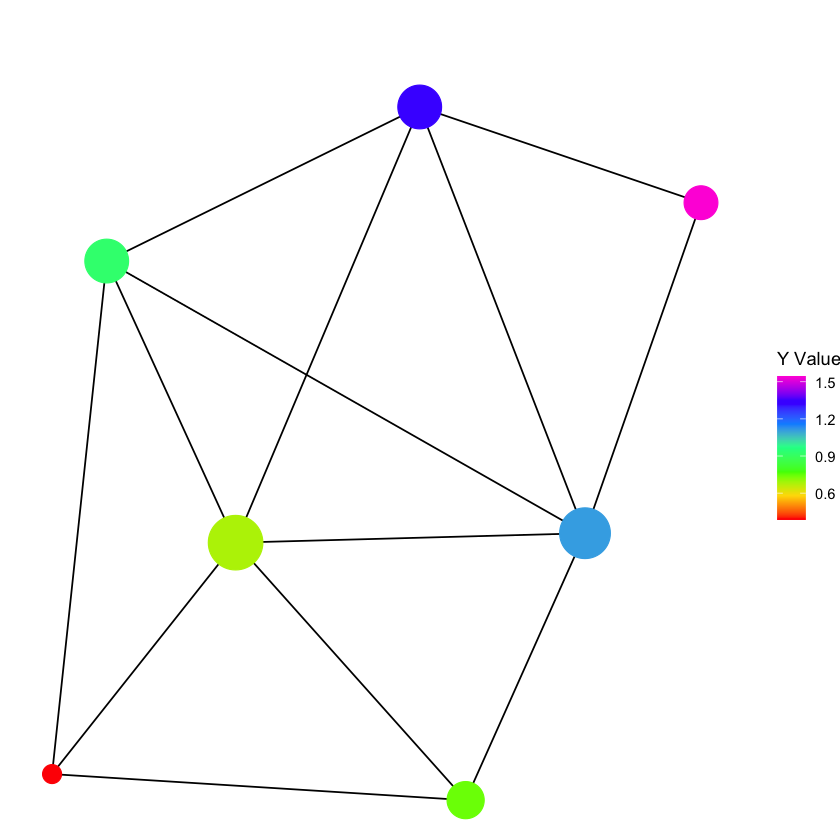

In [86]:
ggplot(ptct, aes(x = X1, y = X2, color = Color)) +
  geom_segment(data = pairs,
               aes(x = x1, y = y1, xend = x2, yend = y2),
               color = "black") +
  geom_point(aes(color = Color, size = C_scaled)) +
  scale_color_gradientn(colours = rainbow(7)) +  # Rainbow color scale
  scale_size(range = c(5, 15)) + 
  guides(size = "none") + 
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_void() +
  labs(title = "",
       x = "", y = "", color = "Y Value")

ggsave("demo203.png", dpi = 300, width = 5.5, height = 4, units = "in")

A final update to the code allows the points to be labelled. These numbers are the equivalent of the numbers on the TDABM plot balls. The numbers only inform on the order that the landmarks were selected in

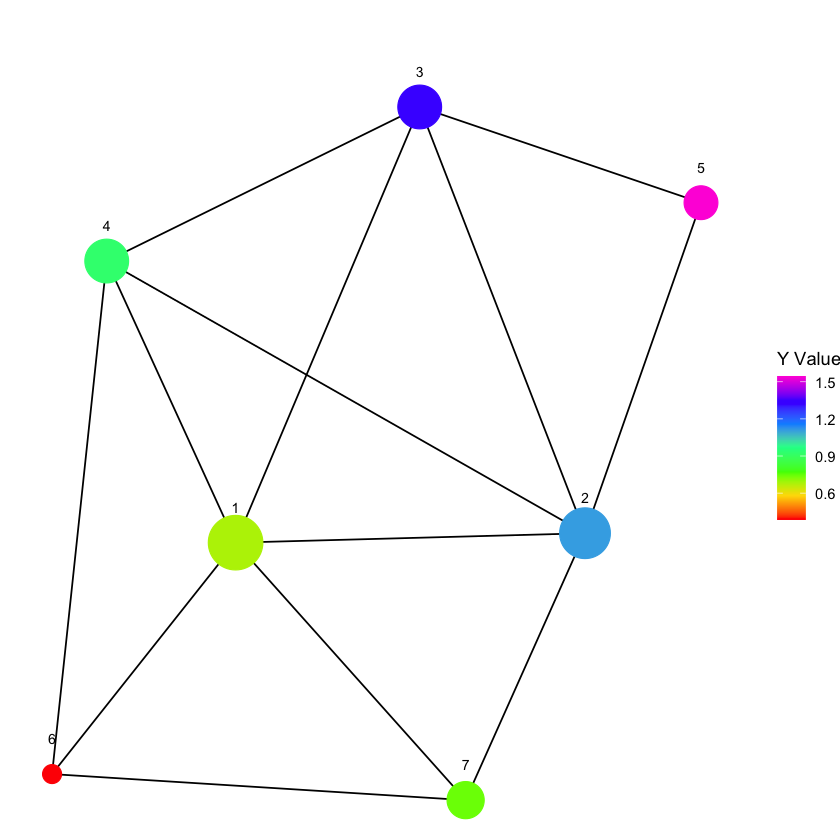

In [87]:
ggplot(ptct, aes(x = X1, y = X2, color = Color)) +
  geom_segment(data = pairs,
               aes(x = x1, y = y1, xend = x2, yend = y2),
               color = "black") +
  geom_point(aes(color = Color, size = C_scaled)) +
  geom_text(aes(label = rownames(ptct)), size = 3, vjust = -3, color="black")+
  scale_color_gradientn(colours = rainbow(7)) +  # Rainbow color scale
  scale_size(range = c(5, 15)) + 
  guides(size = "none") + 
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_void() +
  labs(title = "",
       x = "", y = "", color = "Y Value")

ggsave("demo204.png", dpi = 300, width = 5.5, height = 4, units = "in")

## Implementing BallMapper

In this section I introduce the BallMapper() function which implements TDABM in R. The function has three inputs. A dataframe of axis variables, X, the coloration variable, Y, and the ball radius.

Preparation thus requires the creation of the data frames

In [88]:
xd<-as.data.frame(cbind.data.frame(df1$X1,df1$X2))
yd<-as.data.frame(df1$Y)

names(xd)<-c("X1","X2")
names(yd)<-"Y"

A BallMapper object is generated by implementing the function. The guide contains details of the elements of a BallMapper object

In [89]:
bm1<-BallMapper(xd,yd,0.4)

To view the TDABM graph the igraph package is used

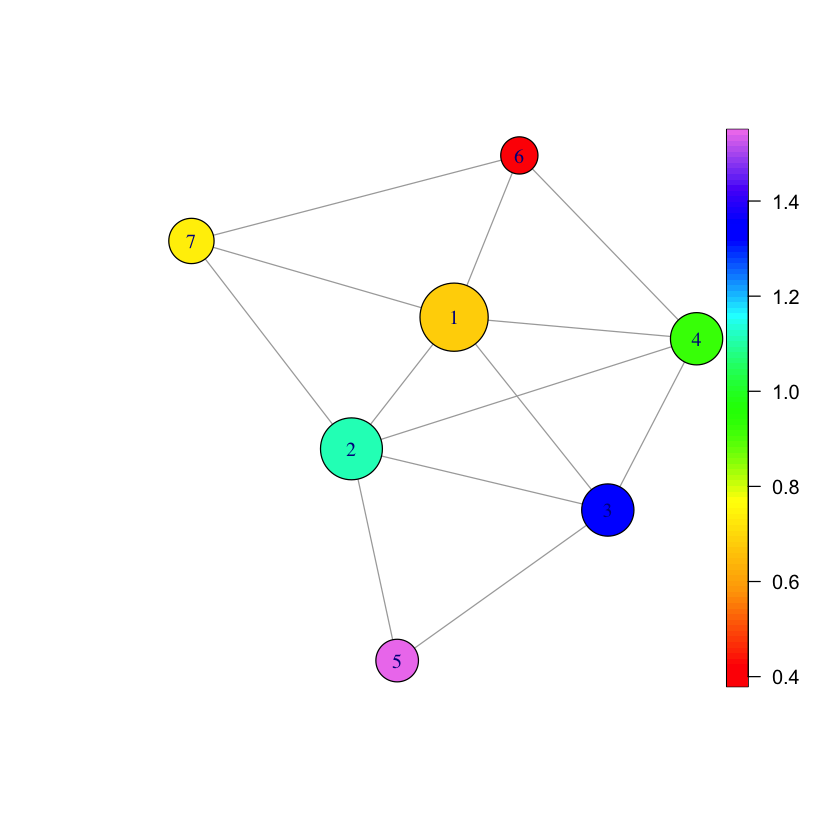

In [90]:
ColorIgraphPlot(bm1,seed_for_plotting=123)

A png file of this can be created straightforwardly

In [91]:
png("tdabmplot.png",width=5.5,height=4,units="in",res=300)
ColorIgraphPlot(bm1,seed_for_plotting=123)
dev.off()

pdf 
  2

Because the TDABM plot is abstract, it is not immediate to see which balls have the highest/lowest values of X1 and X2. By creating dataframes of the two axis variables separately, the coloration can be made to be by these two axis datasets.

In [92]:
yd1<-as.data.frame(df1$X1)
yd2<-as.data.frame(df1$X2)

bm2<-BallMapper(xd,yd1,0.4)
bm3<-BallMapper(xd,yd2,0.4)

png("tdabmplotx1.png",width=5.5,height=4,units="in",res=300)
ColorIgraphPlot(bm2,seed_for_plotting=123)
dev.off()
png("tdabmplotx2.png",width=5.5,height=4,units="in",res=300)
ColorIgraphPlot(bm3,seed_for_plotting=123)
dev.off()

pdf 
  2

pdf 
  2

One element of the BallMapper object is the coloration. The coloration is extracted with the $ notation as follows

In [93]:
cd1<-as.data.frame(bm1$color)

A data frame of colors is then created to allow links with other elements of the BallMapper object

In [94]:
cd1$Ball<-seq(1:nrow(cd1))
names(cd1)<-c("TDABM_Coloration","Ball")

I merge the data with the point counts and ball information created in the manual TDABM. This will confirm the similarity of the balls

In [96]:
ptct<-merge(ptct,cd1,by="Ball")
head(ptct)

Ball X1         X2        id Count C_scaled  Color     TDABM_Coloration.x
1 1    0.28757752 0.3536061 1  223   12.000000 0.6791395 0.6791395         
2 2    0.78830514 0.3664414 2  195    9.971014 1.1093547 1.1093547         
3 3    0.55143501 0.9450351 3  152    6.855072 1.3407098 1.3407098         
4 4    0.10292468 0.7358994 4  152    6.855072 0.9242305 0.9242305         
5 5    0.95450365 0.8150815 5  109    3.739130 1.5448412 1.5448412         
6 6    0.02461368 0.0394992 6   85    2.000000 0.3848312 0.3848312         
  TDABM_Coloration.y
1 0.6791395         
2 1.1093547         
3 1.3407098         
4 0.9242305         
5 1.5448412         
6 0.3848312

The Color variable was created by the manual implementation, the TDABM_Coloration was created by the algorithm. It can be seen that this is identical

To generate information about the points within each ball a user defined function is created. This converts the list generated by BallMapper into a form which can be best used with other elements of the data. For example a version of the data that has text describing the individual data points. In the artificial example, the code is only included to help with the understanding

In [97]:
points_to_balls<-function(l){
  a001<-length(l$landmarks)
  a1<-matrix(0,nrow=1,ncol=2)
  a1<-as.data.frame(a1)
  names(a1)<-c("pt","ball")
  for(i in 1:a001){
    a<-as.data.frame(l$points_covered_by_landmarks[i])
    names(a)<-"pt"
    a$ball<-i
    a1<-rbind.data.frame(a1,a)
   }
  a1<-a1[2:nrow(a1),]
  return(a1)
}

The newly created points_to_balls() function is then applied to the artificial dataset

In [99]:
pb1<-points_to_balls(bm1)
names(pb1)<-c("pt","Ball")

The pb1 data can be merged with the underlying data frame

In [100]:
df1$pt<-seq(1:nrow(df1)) 
df2<-merge(df1,pb1,by="pt")

As a further example of the use of BallMapper, I can generate a color variable based on the standard deviation. The newly merged dataset can be grouped by the ball number so that the standard deviation of Y can be calculated for each ball. This can be adjusted for any other function

In [101]:
df2g<-group_by(df2,Ball)
df2s<-summarise(df2g,sdy = sd(Y), .groups="drop")
df2s<-as.data.frame(df2s)
names(df2s)<-c("Ball","SDY")

The coloration is then updated

In [102]:
bm1$coloring<-df2s$SDY

As a final step plot the bm1 object in the normal way. The coloring is updated.

pdf 
  2

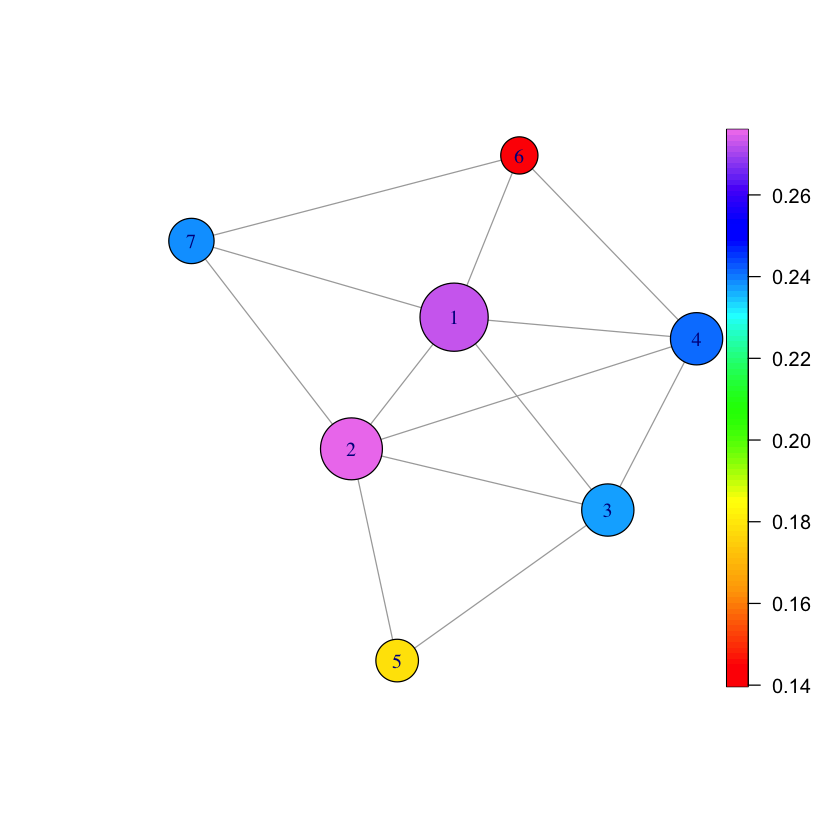

In [103]:
ColorIgraphPlot(bm1,seed_for_plotting=123)

png("tdabmplotsdy.png",width=5.5,height=4,units="in",res=300)
ColorIgraphPlot(bm1,seed_for_plotting=123)
dev.off()

This guide has shown just a fraction of the possible uses of TDABM. The manual implementations provide the inference for the BallMapper plot that is generated by the BallMapper function in R and the TDABM algorithm as implemented in Dlotko (2019).